# <center>Project 1</center>

Authored by Joshua Burrows and Maksim Nikiforov.

## <center>1 Introduction</center>

The sections that follow explore data between the years 1988 and 2020 on 1061 used motorcycles, including their make and model, selling price, year of purchase, and their odometer reading. The [source](https://www.kaggle.com/nehalbirla/motorcycle-dataset?select=BIKE+DETAILS.csv) of the information is attributed to www.bikewale.com. The table below lists descriptions for all variables in the data.


| Variable         | Description |    
|--------------|-----------|
| name | Make and model of the motorcycle |
| selling_price | Price at which the seller is selling the motorcycle (in Indian rupees) | 
| year | The year in which the motorcycle was bought | 
| seller_type | Seller category (individual or a dealer) | 
| owner | Number of previous owners | 
| km_driven | Odometer reading | 
| ex_showroom_price | Showroom price of the motorcycle | 



A preview of the data set is included for reference. Additionally, the following packages are used to read, summarize, and visualize the data:

- [pandas](https://pandas.pydata.org/) - a "fast, powerful, flexible and easy to use open source data analysis and manipulation tool" that provides support for DataFrames and the `.read_csv()` method for ingestinv CSV files.
- [matplotlib](https://matplotlib.org/) - a "comprehensive library for creating static, animated, and interactive visualizations in Python" that includes the `.pyplot` interface for creating scatter plots, box and whisker plots, bar plots, and other graphics.
- [numpy](https://numpy.org/) - the "fundamental package for scientific computing with Python" with support for arrays, array manipulation, and mathematical summary methods.
- [scipy](https://scipy.org/) - provides "fundamental algorithms for scientific computing in Python" and includes the `.stats` module for statistical functions. `scipy.stats.linregress` is used to corroborate the output of the linear least-squares regression of our user-defined functions.

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Read in the data
bike_data = pd.read_csv("bikeDetails.csv")

# Convert categorical variables to type "category"
bike_data.seller_type = bike_data.seller_type.astype("category")
bike_data.owner = bike_data.owner.astype("category")

# Display a small snippet of the data
bike_data.head()

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price
0,Royal Enfield Classic 350,175000,2019,Individual,1st owner,350,NaN
1,Honda Dio,45000,2017,Individual,1st owner,5650,NaN
2,Royal Enfield Classic Gunmetal Grey,150000,2018,Individual,1st owner,12000,148114.0
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,Individual,1st owner,23000,89643.0
4,Yamaha SZ [2013-2014],20000,2011,Individual,2nd owner,21000,NaN


Section 2 provides descriptive statistics for the data, such as measures of central tendency, as well as visualizations for the distribution of observations. Section 3 explores ways to predict price for a motorcycle based on its odometer reading. This section also includes custom function definitions to yield such predictions and summarizes how two numerical methods - grid search and gradient descent - help gauge their quality. 

## <center>2 Exploratory Data Analysis</center>
### <center>2.1 Numeric Summaries</center>

Our data contains observations on 1061 motorcycles. 

In [59]:
# View the number of rows and columns in our data frame
bike_data.shape

(1061, 7)

Showroom prices are only available for 626 motorcycles and is missing for the remaining 435, as designated by the `NaN` marker. Note that the _pandas_ `.describe()` method for descriptive statistics excludes `NaN` values from its summaries. 

The median, indicated as the 50 percentile, is lower than the mean for all three of our numeric columns, indicating that our distribution of data is right-skewed. 

In [60]:
# Provide descriptive statistics for numerical columns (excluding "year") 
num_vars = bike_data[["selling_price", "km_driven", "ex_showroom_price"]]
num_vars.describe().round(1)

,selling_price,km_driven,ex_showroom_price
count,1061.0,1061.0,626.0
mean,59638.2,34359.8,87958.7
std,56304.3,51623.2,77496.6
min,5000.0,350.0,30490.0
25%,28000.0,13500.0,54852.0
50%,45000.0,25000.0,72752.5
75%,70000.0,43000.0,87031.5
max,760000.0,880000.0,1278000.0


When we group information by the year in which motorcycles were bought, we find that the years 2014-2019 had the most motorcycle sales. In the table below, selling prices for the years prior to 2005 are excluded because, in six of those years, data is available for only one motorcycle sale and the median conveys little meaning. In the remaining years, data is available for fewer than seven motorcycle sales.

In [61]:
# Create numeric summaries for selling_price and group by year
annual_num_summaries = bike_data \
.groupby("year") \
.agg(
    max_selling_price = ("selling_price", max), 
    min_selling_price = ("selling_price", min),
    median_selling_price = ("selling_price", np.median),
    standard_dev = ("selling_price", np.std)
)

# Identify number of motorcycles sold every year
num_sold = bike_data[["year", "name"]].groupby("year").count().sort_values(by="year", ascending=False)

# Merge number of motorcycles sold every year into our summaries data frame
annual_num_summaries["num_sold"] = num_sold["name"]

# Display numeric summaries for the last 10 years while rounding standard deviation
annual_summaries = annual_num_summaries.sort_values(by="year", ascending=False).head(16).round(1)
annual_summaries

,max_selling_price,min_selling_price,median_selling_price,standard_dev,num_sold
year,,,,,
2020,190000,175000,185000.0,7637.6,3
2019,760000,40000,89999.5,96703.4,86
2018,300000,30000,75000.0,46394.5,131
2017,425000,18000,60000.0,50627.9,133
2016,300000,23000,50000.0,36006.2,107
2015,185000,20000,45000.0,35627.3,100
2014,330000,15000,40000.0,36973.1,91
2013,750000,15000,35000.0,85138.2,73
2012,100000,12000,30000.0,19431.2,70


There is a general increase in the median selling price between 2005 and 2020. This increase can be visualized with the line plot below. The data set includes information on only 3 sales in 2020, and the minimum selling price of 175000 (nearly double the median in 2019) results in a spike in the plot.   

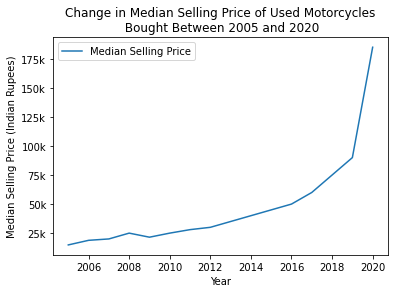

In [62]:
annual_summaries.plot.line(y="median_selling_price")
plt.title("Change in Median Selling Price of Used Motorcycles\n Bought Between 2005 and 2020")
plt.ylabel("Median Selling Price (Indian Rupees)")
plt.xlabel("Year")
plt.yticks(ticks = [25000, 50000, 75000, 100000, 125000, 150000, 175000],
           labels = ["25k", "50k", "75k", "100k", "125k", "150k", "175k"])
plt.legend(["Median Selling Price"])
plt.show()

Two motorcycles in the data set - the Suzuki GSX S750 and the Harley-Davidson Street Bob - are priced at more than double the value of the next most-expensive motorcycle, the Yamaha YZF R3. The Suzuki model and the Yamaha model both have particularly low odometer readings of 2800 kilometers and 1127 kilometers, respectively.  

In [63]:
# Create average price and km summaries for motorcycles
highest_lowest_selling = bike_data \
.groupby("name") \
.agg(
    mean_selling_price = ("selling_price", np.mean),
    mean_km_driven = ("km_driven", np.mean)
)

# Count number of sales for each make and model
names_sold = bike_data \
.groupby("name").count()

# Merge number of sales into price and km data frame
highest_lowest_selling["num_sold"] = names_sold["selling_price"]

# Show top 10 highest-priced motorcyles
highest_lowest_selling.sort_values(by="mean_selling_price", ascending=False).head(10).round(0)

,mean_selling_price,mean_km_driven,num_sold
name,,,
Suzuki GSX S750,760000.0,2800.0,1
Harley-Davidson Street Bob,750000.0,12000.0,1
Yamaha YZF R3,365000.0,1127.0,1
Kawasaki Ninja 650 [2018-2019],362500.0,12800.0,2
Harley-Davidson Street 750,330000.0,6500.0,1
Kawasaki Ninja 300,300000.0,9800.0,1
BMW G310GS,300000.0,2500.0,1
Royal Enfield Continental GT 650,299000.0,1500.0,1
Royal Enfield Interceptor 650,271667.0,5233.0,3


Four of the ten lowest-priced motorcycles, averaging just under 10,000 Indian rupees, were manufactured by Hero Honda, with the Hero Honda CD100SS having 646,000 km on its odometer. The remaining motorcycles in the list were manufactured by the TVS Motor Company or by Bajaj. 

In [64]:
# Show top 10 lowest-priced motorcyles
highest_lowest_selling.sort_values(by="mean_selling_price", ascending=True).head(10).round(0)

,mean_selling_price,mean_km_driven,num_sold
name,,,
TVS Excel,5000.0,60000.0,1
Hero Honda Passion,9000.0,66191.0,1
Hero Honda CD100SS,10000.0,646000.0,1
Hero Honda CBZ,10000.0,48000.0,1
TVS Centra,10000.0,50000.0,1
Hero Honda Street Smart,10000.0,24000.0,1
Bajaj Boxer,12333.0,21833.0,3
Bajaj Super,13000.0,28000.0,2
TVS Scooty Pep DLX,14500.0,44000.0,1


### <center>2.2 Scatter Plots</center>

This section uses scatter plots to explore the relationship between `selling_price` and other numeric variables. 

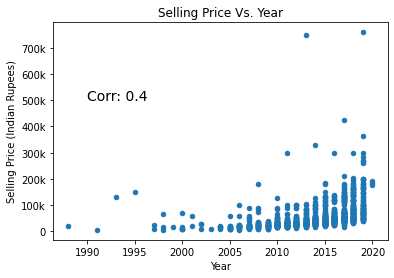

In [65]:
# Create a scatter plot of selling_price and year
year_sp_corr, _ = stats.pearsonr(x = bike_data.year, y = bike_data.selling_price)

bike_data.plot.scatter(x = "year", y = "selling_price")
plt.title("Selling Price Vs. Year")
plt.xlabel("Year")
plt.ylabel("Selling Price (Indian Rupees)")
plt.yticks(ticks = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000],
           labels = ["0", "100k", "200k", "300k", "400k", "500k", "600k", "700k"])
plt.text(1990, 500000, "Corr: " + str(round(year_sp_corr, 2)), fontsize = 14)
plt.show()

There is a mild correlation between `selling_price` and `year`. But the scatter plot suggests a quadratic relationship. Since taking the log turns quadratic things into linear things, it's worth plotting the log of `selling_price` against `year` to see what we find. 

In [66]:
bike_data["log_selling_price"] = np.log(bike_data.selling_price)

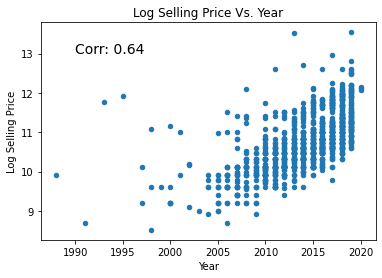

In [67]:
# Create a scatter plot of log_selling_price and year 
year_log_sp_corr, _ = stats.pearsonr(x = bike_data.year, y = bike_data.log_selling_price)

bike_data.plot.scatter(x = "year", y = "log_selling_price")
plt.title("Log Selling Price Vs. Year")
plt.xlabel("Year")
plt.ylabel("Log Selling Price")
plt.text(1990, 13, "Corr: " + str(round(year_log_sp_corr, 2)), fontsize = 14)
plt.show()

There is in fact a stronger linear relationship between the log of `selling_price` and `year`. 

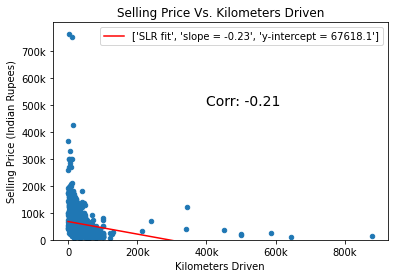

In [68]:
# Create a scatter plot of selling_price and km_driven 
km_sp_corr, _ = stats.pearsonr(x = bike_data.km_driven, y = bike_data.selling_price)

slope, intercept, *_ = stats.linregress(bike_data.km_driven, bike_data.selling_price)

x = np.array([float(x) for x in range(0, int(max(bike_data.km_driven))+1)])
yhat = intercept + slope * x
fit = pd.DataFrame(zip(x, yhat))

bike_data.plot.scatter(x = "km_driven", y = "selling_price")
plt.plot(x, yhat, c = "Red", label = ["SLR fit", "slope = " + str(slope.round(2)), "y-intercept = " + str(intercept.round(1))])
plt.title("Selling Price Vs. Kilometers Driven")
plt.xlabel("Kilometers Driven")
plt.ylabel("Selling Price (Indian Rupees)")
plt.xticks(ticks = [0, 200000, 400000, 600000, 800000],
           labels = ["0", "200k", "400k", "600k", "800k"])
plt.yticks(ticks = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000],
           labels = ["0", "100k", "200k", "300k", "400k", "500k", "600k", "700k"])
plt.text(400000, 500000, "Corr: " + str(round(km_sp_corr, 2)), fontsize = 14)

# Cut off y-axis at y=0 to prevent trendline from dipping below 0 Indian rupees
x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,0,y2))
plt.legend()

plt.show()

There is a weak linear relationship between `selling_price` and `km_driven`. A basic trend line yields a y-intercept of 67,618.1 and a slope of -0.23. It is clear that that relationship will get stronger if we remove the outliers. Let's see what happens when bikes with greater than 200,000 km are removed. 

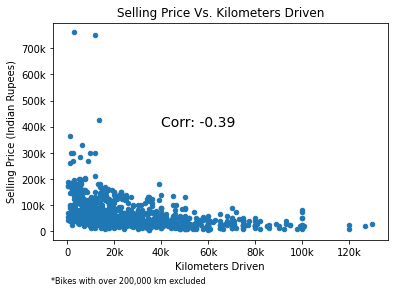

In [69]:
# Try without outlier kilometerage 
bike_data_low_km = bike_data[bike_data.km_driven <= 200000]

km_sp_corr_low_km, _ = stats.pearsonr(x = bike_data_low_km.km_driven, 
                                      y = bike_data_low_km.selling_price)

bike_data_low_km.plot.scatter(x = "km_driven", y = "selling_price")
plt.title("Selling Price Vs. Kilometers Driven")
plt.xlabel("Kilometers Driven")
plt.ylabel("Selling Price (Indian Rupees)")
plt.xticks(ticks = [0, 20000, 40000, 60000, 80000, 100000, 120000],
           labels = ["0", "20k", "40k", "60k", "80k", "100k", "120k"])
plt.yticks(ticks = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000],
           labels = ["0", "100k", "200k", "300k", "400k", "500k", "600k", "700k"])
plt.text(40000, 400000, "Corr: " + str(round(km_sp_corr_low_km, 2)), fontsize = 14)
plt.text(-7000, -200000, "*Bikes with over 200,000 km excluded", fontsize = 8)
plt.show()

The linear relationship does in fact get stronger when the outliers are removed. Is removing the outliers justified? It is plausible that sales of high kilometerage bikes are rare, so we may not have enough data on those sales for a pattern to emerge. So it does not seem unreasonable to remove the outliers in this case.  

Again, the relationship appears quadratic, so let's take the log. 

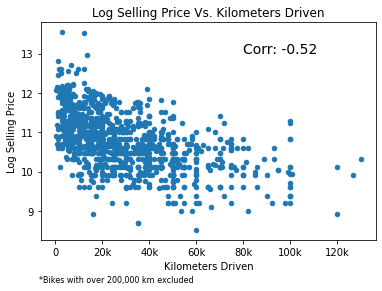

In [70]:
# Now there appears to be a quadratic relationship. Try log. 
km_log_sp_corr_low_km, _ = stats.pearsonr(x = bike_data_low_km.km_driven, 
                                          y = bike_data_low_km.log_selling_price)

bike_data_low_km.plot.scatter(x = "km_driven", y = "log_selling_price")
plt.title("Log Selling Price Vs. Kilometers Driven")
plt.xlabel("Kilometers Driven")
plt.ylabel("Log Selling Price")
plt.xticks(ticks = [0, 20000, 40000, 60000, 80000, 100000, 120000],
           labels = ["0", "20k", "40k", "60k", "80k", "100k", "120k"])
plt.text(80000, 13, "Corr: " + str(round(km_log_sp_corr_low_km, 2)), fontsize = 14)
plt.text(-7000, 7.2, "*Bikes with over 200,000 km excluded", fontsize = 8)
plt.show()

After removing outliers and taking the log, a stronger linear relationship is uncovered. 

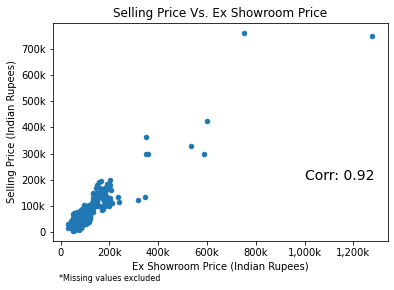

In [71]:
# Scatter plot of selling_price and ex_showroom_price 
bike_data_drop_na = bike_data.dropna()

show_sp_corr, _ = stats.pearsonr(x = bike_data_drop_na.ex_showroom_price, 
                                 y = bike_data_drop_na.selling_price)

bike_data_drop_na.plot.scatter(x = "ex_showroom_price", y = "selling_price")
plt.title("Selling Price Vs. Ex Showroom Price")
plt.xlabel("Ex Showroom Price (Indian Rupees)")
plt.ylabel("Selling Price (Indian Rupees)")
plt.yticks(ticks = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000],
           labels = ["0", "100k", "200k", "300k", "400k", "500k", "600k", "700k"])
plt.xticks(ticks = [0, 200000, 400000, 600000, 800000, 1000000, 1200000],
           labels = ["0", "200k", "400k", "600k", "800k", "1,000k", "1,200k"])
plt.text(1000000, 200000, "Corr: " + str(round(show_sp_corr, 2)), fontsize = 14)
plt.text(-7000, -185000, "*Missing values excluded", fontsize = 8)
plt.show()

The linear relationship between `selling_price` and `ex_showroom_price` is extremely strong. 

### <center>2.3 Box Plots</center>

This section explores the relationship between `selling_price` and the categorical variables `seller_type` and `owner`. 

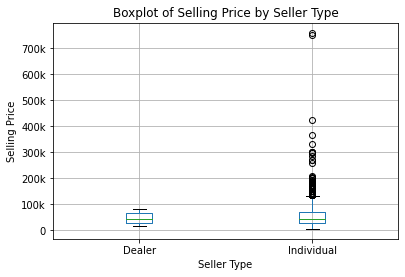

In [72]:
# Create a box plot of selling_price by seller_type 
bike_data.boxplot(column = ["selling_price"], 
                  by = "seller_type")
plt.suptitle("")
plt.title("Boxplot of Selling Price by Seller Type")
plt.xlabel("Seller Type")
plt.ylabel("Selling Price")
plt.yticks(ticks = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000],
           labels = ["0", "100k", "200k", "300k", "400k", "500k", "600k", "700k"])
plt.show()

There are so many outliers that it's difficult to see what's going on. Let's remove them from the plot. 

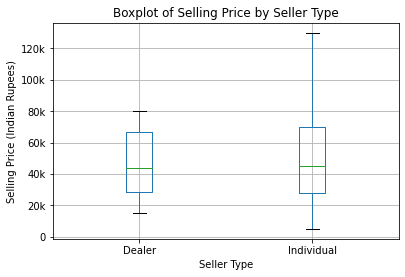

In [73]:
# Remove outliers from the previous boxplot 
bike_data.boxplot(column = "selling_price", 
                  by = "seller_type",
                  showfliers = False)
plt.suptitle("")
plt.title("Boxplot of Selling Price by Seller Type")
plt.xlabel("Seller Type")
plt.ylabel("Selling Price (Indian Rupees)")
plt.yticks(ticks = [0, 20000, 40000, 60000, 80000, 100000, 120000],
           labels = ["0", "20k", "40k", "60k", "80k", "100k", "120k"])
plt.show()

It is difficult to draw conclusions because only six bikes in the data set were sold by dealers. This is probably why we see a wider range in the `selling_price` of bikes sold by individuals. 

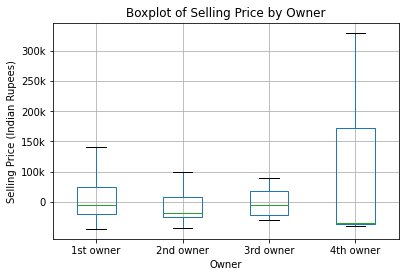

In [74]:
# Create a boxplot of selling_price by owner
bike_data.boxplot(column = "selling_price", 
                  by = "owner",
                  showfliers = False)
plt.suptitle("")
plt.title("Boxplot of Selling Price by Owner")
plt.xlabel("Owner")
plt.ylabel("Selling Price (Indian Rupees)")
plt.yticks(ticks = [50000, 100000, 150000, 200000, 250000, 300000],
           labels = ["0", "100k", "150k", "200k", "250k", "300k"])
plt.show()

Again, drawing conclusions about third and fourth owner bikes is difficult because only 11 were sold by their third owner, and only 3 were sold by their fourth owner. 

There were 123 bikes sold by their second owner and 924 sold by their first owner, so it is more reasonable to compare these categories. One thing that stands out is that the mean `selling_price` of bikes sold by their second owner is lower than the mean `selling_price` of bikes sold by their first owner. The IQR of `selling_price` is also smaller for second owner bikes than first owner bikes. 

### <center>2.4 Contingency Table and Bar Plot</center>

This section compares `seller_type` and `owner`.

In [75]:
seller_owner_tab = pd.crosstab(bike_data.seller_type, bike_data.owner)
seller_owner_tab

owner,1st owner,2nd owner,3rd owner,4th owner
seller_type,,,,
Dealer,4,2,0,0
Individual,920,121,11,3


Not very many of the bikes were sold by dealers, and only a few were sold by their third or fourth owner. 

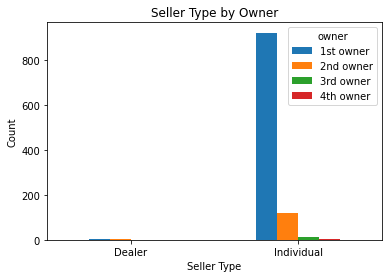

In [76]:
seller_owner_tab.plot.bar()
plt.title("Seller Type by Owner")
plt.xlabel("Seller Type")
plt.ylabel("Count")
plt.xticks(rotation = 0)
plt.show()

Individual sales by owner are by far the most common type of sale. 

## <center>3 Prediction of `selling_price`

Scatter plots in the previous section have shown a low negative correlation between `selling_price` (the price at which a seller is selling their motorcycle) and `km_driven` (the odometer reading of the motorcycle). In this section, we continue to explore these two variables and apply regression analysis. Our objective is to predict values of `selling_price` and to quantify the quality of our prediction using the root mean square error (RMSE) as the metric,

$$
RMSE(c) = \sqrt{\frac{1}{n}\sum_{i=1}^{n} {(y_i-c)^2}}
$$

where $y_i,...,y_n$ are our `selling_price` values and $c$ is our prediction.

### <center>3.1 Grid Search Algorithm</center>

#### <center>Just _y_ (`selling_price`)

In this subsection, we determine which prediction, $c$, yields the smallest RMSE value. To do this, we create a list of candidate values and iteratively subtract them from the values of `selling_price`. Since the calculus-based answer for this turns out to be the sample mean, we will center our candidate values around the mean of `selling_price`, $59638.2$, as determined in section 2.1. 

In [77]:
# Create a grid of prediction values (c) for selling price
# Center them around the mean, based on calculus
selling_price_grid = [x for x in range(40000, 80000, 10)]

Next, we create a user-defined function, `calc_grid_simple()` which accepts both our `selling_price` series and our list of predictions, `selling_price_grid`. The function initiates an empty dictionary, `rmse`, to store our prediction and the resulting RMSE as key-value pairs. Next, the function calculates a squared sum of differences and the root of the quotient of this sum and the length of our `selling_price` series, as directed by the RMSE equation. Lastly, the function identifies the key-value pair with the minimal RMSE value and returns it as a tuple, `(RMSE, c)`.  

In [78]:
# Grid search algorithm
def calc_grid_simple(y, c):
    # Initialize empty array for RMSE
    rmse = {}
    for val in range(0, len(c)):
        diff = (y - c[val])**2
        rmse[c[val]] = np.sqrt(sum(diff)/len(y))
    # Find minimum value in dictionary and its associated key
    rmse_key_val = min(zip(rmse.values(), rmse.keys()))
    # Return the key as our prediction
    return rmse_key_val

With `selling_price` and `selling_price_grid` as inputs, our function returns a prediction of `c = 59640`, which matches with our expected mean value of `selling_price`, $59,638.2$. We can edge this value closer to the mean by using a step value smaller than 10, such as 1, in our search grid (however, this increases computing time). The RMSE associated with this prediction is $56,277.8$.

In [79]:
# Run the algorithm on the selling_price variable and determine the optimal prediction
optimal_selling_c = calc_grid_simple(bike_data.selling_price, selling_price_grid)
print("Our selling_price prediction (c):", format(optimal_selling_c[1], ","), "\nAssociated RMSE (optimal):", format(optimal_selling_c[0].round(1), ","))

Our selling_price prediction (c): 59,640 
Associated RMSE (optimal): 56,277.8


To confirm that our function generalizes to values other than those in the `selling_price` series, we can use the `km_driven` series. Our search grid centers around the mean value of `km_driven`, $34,359.8$.

In [80]:
# Create a grid of prediction values (c) for km_driven
# Center them around the mean, based on calculus 
km_driven_grid = [x for x in range(10000, 50000, 10)]

Our function yields a prediction of `c = 34360`, which once again aligns with the mean of the supplied Series, `km_driven`. The associated RMSE value is $51,598.8$. 

In [81]:
# To make sure the algorithm generalizes, run it using the km_driven variable as the response
optimal_km_c = calc_grid_simple(bike_data.km_driven, km_driven_grid)
print("Our km_driven prediction (c):", format(optimal_km_c[1], ","), "\nAssociated RMSE (optimal):", format (optimal_km_c[0].round(1), ","))

Our km_driven prediction (c): 34,360 
Associated RMSE (optimal): 51,598.8


#### <center>Using _y_ and Another Numeric Variable, _x_ (`selling_price` and `km_driven`)

In this subsection, we extend our user-defined function to incorporate a single predictor variable, `km_driven`. We do this with the assumption that `selling_price` and `km_driven` are related linearly, so that a "best fitting" regression line of the form

$$
c_{i} = b_{0} + b_{1}x_{i}
$$

may be drawn. Here, $c_{i}$ is our prediction, $b_{0}$ is the y-intercept, $b_{1}$ is the slope, and $x_{i}$ is the value of `km_driven`. The objective is to determine the values of $b_{0}$ and $b_{1}$ that minimize $\sum{(y_i-c_{i})}^2$.

Based on our scatter plot analysis of the relationship between `selling_price` (our $y$ variable) and `km_driven` (our $x$ variable), a reasonable range for $b_0$ is $60,000$ to $70,000$, and a reasonable range for $b_1$ is $-0.20$ to $-0.30$. We can use these values as reference points for our $b_0$ and $b_1$ value grids, respectively, to help us reduce computation time.

In [82]:
# Create grids for b_0 and b_1 based on values found during EDA
b_0 = [x for x in range(60000, 70000, 10)]
b_1 = [x for x in np.arange(-0.20, -0.30, -0.005)]

Next, we expand upon the function defined previously by accepting two additional lists of values for $b_{0}$ and $b_{1}$. We iterate over combinations of these numbers to populate a list of RMSE values for each combination, and we identify the combination with the smallest resulting RMSE.

In [83]:
def calc_grid_complex(y, b0_grid, b1_grid, x):
    # Initialize empty 2D array and an empty dictionary to store b0/b1:RMSE pairs
    column, row = len(b0_grid), len(b1_grid)
    rmse = {}
    rmse_matrix = [[0 for _ in range(row)] for _ in range(column)]
    for b_zero in range(0, len(b0_grid)):
        for b_one in range(0, len(b1_grid)):
            c = b0_grid[b_zero] + b1_grid[b_one] * x
            diff = (y - c)**2
            rmse[b0_grid[b_zero], b1_grid[b_one]] = np.sqrt(sum(diff)/len(y))
    rmse_key_val = min(zip(rmse.values(), rmse.keys()))
    return rmse_key_val

The result of our user-defined function is a tuple of the form `(RMSE, (y-intercept, slope))`, as shown below. For our data set, the optimal RMSE value, $54,987.2$, is given by $b_{0}=67,540 $ and $b_{1}=-0.23$.

In [84]:
min_rmse = calc_grid_complex(bike_data.selling_price, b_0, b_1, bike_data.km_driven)
min_rmse

(54987.1999686615, (67540, -0.23000000000000004))

In [85]:
print("Optimal RMSE from our function:", format(min_rmse[0].round(1), ","), "\nIntercept from our function:", format(min_rmse[1][0], ","), "\nSlope from our function:", min_rmse[1][1])

Optimal RMSE from our function: 54,987.2 
Intercept from our function: 67,540 
Slope from our function: -0.23000000000000004


To predict the `selling_price` for $10,000$, $25,000$, and $35,000$ `km_driven`, we can populate our user-defined function with a list of the requested predictor values. Subsequently, we can iterate over these values using the formula $c_{i} = b_{0} + b_{1}x_{i}$ and the combination of the $b_{0}$ and $b_{1}$ values we identified above. 

In [86]:
# Create array of km_driven for which we wish to make selling_price predictions
km_driven_array = [10000, 25000, 35000]

# Initialize an empty dictionary
prediction = {}

# Populate dictionary with km_driven:selling_price pairs based on b_0, b_1 from our custom function
for km in range(0, len(km_driven_array)):
    prediction[km_driven_array[km]] = min_rmse[1][0] + min_rmse[1][1] * km_driven_array[km]

# Print km_driven:selling_price prediction pairs
for key in prediction.keys():
    print(key, 'km : ', format(prediction[key], ","))

10000 km :  65,240.0
25000 km :  61,790.0
35000 km :  59,490.0


We find that, for an odometer reading of $10,000$ km, our predicted `selling_price` is $65,240$ Indian rupees. For odometer readings of $25,000$ km and $35,000$ km, our predicted prices are $61,790$ and $59,490$ Indian rupees, respectively. We can compare these results to the linear least-squares regression returned by `scipy.stats` package and its `linregress` method.

In [87]:
# Use stats.linregress, with x = km_driven and y = selling_price
# There are many things returned - the first is a slope, the second is an intercept, and 
# the rest is placed into a temporary variable
slope, intercept, *_ = stats.linregress(bike_data.km_driven, bike_data.selling_price)

print("Intercept from stats.linregress:", format(intercept, ","), "\nSlope from stats.linregress:", slope)

Intercept from stats.linregress: 67,618.07212024048 
Slope from stats.linregress: -0.2322456088674644


We find that the `.linregress()` returns a y-intercept of $67,618.1$ and a slope of $-0.23$, both of which are within $0.1%$ of the values returned by our `calc_grid_complex` function. Moreover, the values predicted by `.linregress()` for $10,000$, $25,000$, and $35,000$ `km_driven` are $65,295.6$, $61,811.9$, and $59,489.5$ Indian rupees, which aligns closely with our own findings.

In [88]:
# Initialize an empty dictionary
prediction_stats_package = {}

# Populate dictionary with km_driven:selling_price pairs based on b_0, b_1 from our custom function
for km in range(0, len(km_driven_array)):
    prediction_stats_package[km_driven_array[km]] = intercept + slope * km_driven_array[km]

# Print km_driven:selling_price prediction pairs
for key in prediction_stats_package.keys():
    print(key, 'km : ', format(prediction_stats_package[key].round(1), ","))

10000 km :  65,295.6
25000 km :  61,811.9
35000 km :  59,489.5


### <center>3.2 Gradient Descent Algorithm</center>

This subsection uses a gradient descent algorithm to find the prediction that minimizes RMSE. The gradient descent method is an alternative to the grid search method used in the previous section. 

We know from calculus class that RMSE is minimized when the value of its derivative is zero (we'll leave aside the possibility of maximum points and local extrema). The idea behind the gradient descent algorithm is to incrementally adjust our prediction until the value of the derivative is reasonably close to 0. 

#### <center>Just _y_ (`selling_price`)

We will begin with a constant prediction, $c$. 

In order to create the gradient descent function, we need to create three helper functions: 
- `get_sq_err_loss()`: Returns the squared error between an observation of the target variable, $y$, and the prediction $c$. 
- `get_rmse()`: Returns the root mean square error. Our objective is to minimize this function. 
- `get_diff_quo()`: Returns an estimate of the value of the derivative of RMSE at the prediction $c$. 

In [89]:
def get_sq_err_loss(y, c): 
    return (y - c)**2

In [90]:
def get_rmse(y, c): 
    """
    Takes
        y: a numeric vector of observations of the target variable
        c: a numeric prediction
    Returns 
        Root Mean Squared Error 
    """

    # Find RMSE
    sum = 0

    for i in range(0, len(y)): 
        sum += get_sq_err_loss(y[i], c)

    avg = sum / len(y)

    rmse = np.sqrt(avg)

    return rmse

In [91]:
def get_diff_quo(c, delta, y):
    diff_quo = (get_rmse(y, c + delta) - get_rmse(y, c)) / delta
    return diff_quo

Now we are ready to create the gradient descent function, `get_gd_pred()`. 

This function estimates the value of the derivative at a user specified prediction, `cur_c`. The prediction is then adjusted based on the value of the derivative. If the value of the derivative is positive, the prediction becomes slightly smaller. If it is negative, the prediction becomes slightly bigger. The value of the derivative is then estimated at this new prediction (is will be slightly closer to zero than last time). This process is repeated until the value of the derivative is reasonably close to zero or the user specified maximum number of iterations is reached. 

In [92]:
def get_gd_pred(cur_c, y, max_iterations, num_tol = .0001, step_size = .5, delta = .005): 
    """
    Takes 
        cur_c: An initial prediction
        y: a vector of observations
        num_tol: determines how close the prediction needs to be to the 
                   prediction that minimizes RMSE
        step_size: determines how far the updated prediction is from the input prediction
        delta: used to estimate the derivative of RMSE at c
        max_iterations: how long do you want the algorithm to run before you get bored
    Returns a dictionary containing 
        a prediction 
        the number of iterations that ran (so you know whether the algorithm
            stopped because your prediction is accurate enough or because you 
            hit max_iterations)
        RMSE
    """
    iterations = 0
    
    # Update the prediction depending on the slope of the 
    # estimate of the tangent line of RMSE at c.
    # Repeat until a tolerably accurate prediction is found or max_iterations is met.
    while iterations <= max_iterations: 
        
        iterations += 1
        
        new_c = cur_c - get_diff_quo(cur_c, delta, y) * step_size
        
        if abs(new_c - cur_c) < num_tol:
            cur_c = new_c
            break
        else: 
            cur_c = new_c
    
    # Make sure the iterations count returned is accurate 
    if iterations > max_iterations: 
        iterations = max_iterations 
    
    # Calculate RMSE for our final prediction choice 
    rmse = get_rmse(y = y, c = cur_c)

    return {"pred": cur_c, 
            "RMSE": rmse,
            "iter": iterations}

Let's use `get_gd_pred()` to find a reasonable value of the prediction, $c$. 

We will begin with the suggested starting value, $50,000$, and a maximum of $1,000$ iterations. 

In [93]:
pred_1 = get_gd_pred(cur_c = 50000,
                     y = bike_data.selling_price, 
                     max_iterations = 1000)

print("Prediction: " + format(round(pred_1["pred"], 2), ",") +
      "\nRMSE: " + format(round(pred_1["RMSE"], 2), ",") +
      "\nIterations: " + format(round(pred_1["iter"], 2), ","))

Prediction: 50,084.13
RMSE: 57,082.96
Iterations: 1,000


The resulting prediction $50,084.13$. But we did hit the maximum number of iterations. So it's worth running the function with more iterations, an increased step size, and/or a larger starting value. 

In [94]:
pred_2 = get_gd_pred(cur_c = 60000,
                     y = bike_data.selling_price, 
                     max_iterations = 2000,
                     step_size = 1)

print("Prediction: " + format(round(pred_2["pred"], 2), ",") +
      "\nRMSE: " + format(round(pred_2["RMSE"], 2), ",") +
      "\nIterations: " + format(round(pred_2["iter"], 2), ","))

Prediction: 59,987.36
RMSE: 56,278.84
Iterations: 2,000


This time, `get_gd_pred()` returned a prediction that is smaller than the starting value. That tells us that the best prediction is somewhere between $50,000$ and $60,000$. By playing around a little bit, we can home in on a good value for the prediction. 

In [95]:
pred_3 = get_gd_pred(cur_c = 59635,
                     y = bike_data.selling_price, 
                     max_iterations = 10000,
                     step_size = 2)

print("Prediction: " + format(round(pred_3["pred"], 2), ",") +
      "\nRMSE: " + format(round(pred_3["RMSE"], 2), ",") +
      "\nIterations: " + format(round(pred_3["iter"], 2), ","))

Prediction: 59,635.32
RMSE: 56,277.75
Iterations: 3,022


$59,635.32$ appears to be a good prediction value. The algorithm stopped before the maximum number of iterations was reached, which means that this number is reasonably close to the value that minimizes RMSE. 

To make sure that the algorithm generalizes, let's run it using `km_driven` as the response variable. 

In [96]:
km_driven_pred = get_gd_pred(cur_c = 34000,
                             y = bike_data.km_driven,
                             max_iterations = 1000,
                             step_size = 1)

print("Prediction: " + format(round(km_driven_pred["pred"], 2), ",") +
      "\nRMSE: " + format(round(km_driven_pred["RMSE"], 2), ",") +
      "\nIterations: " + format(round(km_driven_pred["iter"], 2), ","))

Prediction: 34,006.91
RMSE: 51,600.03
Iterations: 1,000


#### <center>Using _y_ and Another Numeric Variable, _x_ (`selling_price` and `km_driven`)

In this subsection, we extend gradient descent function to incorporate a single predictor variable, `km_driven`. Just like the grid search case, we will fit a simple liner regression of the form:  

$$
c_{i} = b_{0} + b_{1}x_{i}
$$

Our goal is to estimate the values of $b_{0}$ and $b_{1}$ that minimize $\sum{(y_i-c_{i})}^2$. This is equivalent to minimizing RMSE. 

The first step is to create four helper functions: 
- `get_sq_err_loss_slr()`: Returns the squared difference between an observation of the target variable, $y$, and a SLR prediction
- `get_rmse_slr()`: Returns the root mean square error. Our objective is to minimize this function. 
- `get_diff_quo_b0()`: Returns an estimate of the value of the derivative of RMSE at the value of the SLR prediction in the direction of b0
- `get_diff_quo_b1()`: Returns an estimate of the value of the derivative of RMSE at the value of the SLR prediction in the direction of b1

In [97]:
def get_sq_err_loss_slr(y, b0, b1, x): 
    return (y - b0 - b1 * x)**2

In [98]:
def get_rmse_slr(y, b0, b1, x): 
    """
    Takes
        y: a numeric vector of observations of the target variable
        b0: intercept
        b1: slope
        x: a numeric vector of observations of the predictor variable 
    Returns 
        Root Mean Squared Error 
    """
    
    # Find RMSE
    sum = 0

    for i in range(0, len(y)): 
        sum += get_sq_err_loss_slr(y[i], b0, b1, x[i])

    avg = sum / len(y)

    rmse = np.sqrt(avg)

    return rmse

In [99]:
def get_diff_quo_b0(y, b0, delta0, b1, x):
    
    new_rmse = get_rmse_slr(y = y, b0 = b0 + delta0, b1 = b1, x = x)
    old_rmse = get_rmse_slr(y = y, b0 = b0, b1 = b1, x = x)
    diff_quo = (new_rmse - old_rmse) / delta0

    return diff_quo

In [100]:
def get_diff_quo_b1(y, b0, b1, delta1, x):
    
    new_rmse = get_rmse_slr(y = y, b0 = b0, b1 = b1 + delta1, x = x)
    old_rmse = get_rmse_slr(y = y, b0 = b0, b1 = b1, x = x)
    diff_quo = (new_rmse - old_rmse) / delta1

    return diff_quo

Now we are ready to create a gradient descent function that incorporates a predictor variable, `get_gd_slr_coeffs()`. 

This function starts with user specified SLR parameters, `cur_b0` and `cur_b1` and does the following: 
1) Estimate the value of the derivative of RMSE in the direction of b0 and adjust b0 based on that value. If the value of the derivative is positive, b0 becomes slightly smaller. If it is negative, b0 becomes slightly bigger. 
2) Estimate the value of the derivative of RMSE in the direction of b1 and adjust b1 based on that value. If the value of the derivative is positive, b1 becomes slightly smaller. If it is negative, b1 becomes slightly bigger. 
3) Repeat steps 1 and 2 until the adjustments made to b0 and b1 taken together become very small or a user specified maximum number of iterations is reached. 

In [1]:
def get_gd_slr_coeffs(cur_b0, cur_b1, x, y, max_iterations, delta0 = .005, delta1 = .0000001, 
                      step_size_b0 = 1, step_size_b1 = 0.000005, num_tol = .0001):
    """
    Takes
        cur_b0, cur_b1: initial values of SLR parameters 
        delta0, delta1: used to estimate the derivative of RMSE at b0, b1
        x: a numeric vector of predictors 
        y: a numeric vector of observations of the target variable
        max_iterations: how long you want the algorithm to run
        step_size_b0, step_size_b1: determine how far the updated parameters
            are from the original parameters
        num_tol: determines how close the prediction needs to be to the 
            prediction that minimizes RMSE
    Returns a dictionary containing 
        estimated b0, b1
        the number of iterations that ran (so you know whether the algorithm
            stopped because your prediction is accurate enough or because you 
            hit max_iterations)
        RMSE 
    """
    
    iterations = 0

    while iterations <= max_iterations: 

        iterations += 1

        # Evaluate at cur_b0 and cur_b1
        diff_quo_b0 = get_diff_quo_b0(y = y,
                                      b0 = cur_b0, 
                                      delta0 = delta0,
                                      b1 = cur_b1,
                                      x = x)

        new_b0 = cur_b0 - diff_quo_b0 * step_size_b0

        # Evaluate at new_b0 and cur_b1
        diff_quo_b1 = get_diff_quo_b1(y = y, 
                                      b0 = new_b0,
                                      b1 = cur_b1,
                                      delta1 = delta1,
                                      x = x)

        new_b1 = cur_b1 - diff_quo_b1 * step_size_b1

        # Get distance between vectors
        cur = np.array((cur_b0, cur_b1))
        new = np.array((new_b0, new_b1))
        dist = np.linalg.norm(new - cur)

        # If distance is below tolerance, end loop. 
        if dist < num_tol: 
            cur_b0 = new_b0
            cur_b1 = new_b1
            break 
        else: 
            cur_b0 = new_b0
            cur_b1 = new_b1
            
    # Make sure the iterations count returned is accurate 
    if iterations > max_iterations: 
        iterations = max_iterations 
        
    # Calculate RMSE using the final parameters 
    rmse = get_rmse_slr(y = y, b0 = cur_b0, b1 = cur_b1, x = x)

    return {"b0": cur_b0, 
            "b1": cur_b1, 
            "RMSE": rmse,
            "iter": iterations}

Let's use `get_gd_slr_coeffs()` to find a reasonable values for $b_{0}$ and $b_{1}$. 

We will begin with the suggested starting values of $b_{0}=60,000$ and $b_{1}=0$ as well as a maximum of $1,000$ iterations. 

In [102]:
params_1 = get_gd_slr_coeffs(cur_b0 = 60000, 
                                 cur_b1 = 0, 
                                 x = bike_data.km_driven, 
                                 y = bike_data.selling_price, 
                                 max_iterations = 1000)

print("Estimate of b0: " + format(round(params_1["b0"], 2), ",") +
      "\nEstimate of b1: " + str(round(params_1["b1"], 2)) +
      "\nRMSE: " + format(round(params_1["RMSE"], 2), ",") +
      "\nIterations: " + format(round(params_1["iter"], 2), ","))

Estimate of b0: 60,094.56
Estimate of b1: -0.16
RMSE: 55,342.51
Iterations: 1,000


The resulting estimates are $b_{0}=60,094.56$ and $b_{1}=-0.16$. But we did hit the maximum number of iterations. So it's worth running the function with more iterations, an increased step size, and/or a larger starting value. 

In [103]:
params_2 = get_gd_slr_coeffs(cur_b0 = 70000, 
                             cur_b1 = -.5, 
                             x = bike_data.km_driven, 
                             y = bike_data.selling_price, 
                             max_iterations = 2000)

print("Estimate of b0: " + format(round(params_2["b0"], 2), ",") +
      "\nEstimate of b1: " + str(round(params_2["b1"], 2)) +
      "\nRMSE: " + format(round(params_2["RMSE"], 2), ",") +
      "\nIterations: " + format(round(params_2["iter"], 2), ","))

Estimate of b0: 69,941.17
Estimate of b1: -0.25
RMSE: 55,021.07
Iterations: 2,000


This time, `get_gd_slr_coeffs()` returned an estimate of $b_{0}$ that is smaller than the starting value and an estimate of $b_{1}$ that is larger than the starting value. That tells us that the best value for $b_{0}$ is between $60,000$ and $70,000$, and the best value for $b_{1}$ is between $0$ and $-0.5$ By playing around a little bit, we can home in on a good values for the parameters. 

In [104]:
params_3 = get_gd_slr_coeffs(cur_b0 = 67615, 
                             cur_b1 = -.3, 
                             x = bike_data.km_driven, 
                             y = bike_data.selling_price, 
                             max_iterations = 5000)

print("Estimate of b0: " + format(round(params_3["b0"], 2), ",") +
      "\nEstimate of b1: " + str(round(params_3["b1"], 2)) +
      "\nRMSE: " + format(round(params_3["RMSE"], 2), ",") +
      "\nIterations: " + format(round(params_3["iter"], 2), ","))

Estimate of b0: 67,615.12
Estimate of b1: -0.23
RMSE: 54,987.08
Iterations: 17


$67,615.12$ and $-0.23$ appear to be good estimates for $b_{0}$ and $b_{1}$, respectively. The algorithm stopped before the maximum number of iterations was reached, which means that, even if we let it continue running, the estimates of $b_{0}$ and $b_{1}$ wouldn't have changed very much. 

Let's use these values of $b_{0}$ and $b_{1}$ to predict the `selling_price` of bikes driven $10,000$, $25,000$, and $35,000$ kilometers.  

In [105]:
selling_price_10 = params_3["b0"] + params_3["b1"]*10000
selling_price_25 = params_3["b0"] + params_3["b1"]*25000
selling_price_35 = params_3["b0"] + params_3["b1"]*35000

print("We predict that a bike that has been driven 10,000 km will sell for " + \
      format(round(selling_price_10, 2), ",") + " rupees." +
      "\nWe predict that a bike that has been driven 25,000 km will sell for " + \
      format(round(selling_price_25, 2), ",") + " rupees." +
      "\nWe predict that a bike that has been driven 35,000 km will sell for " + \
      format(round(selling_price_35, 2), ",") + " rupees.")

We predict that a bike that has been driven 10,000 km will sell for 65,292.47 rupees.
We predict that a bike that has been driven 25,000 km will sell for 61,808.5 rupees.
We predict that a bike that has been driven 35,000 km will sell for 59,485.85 rupees.
